<a href="https://colab.research.google.com/github/ttjh1234/Study_MLDL/blob/main/chapter08_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 이미지 분류

**합성곱의 개요**



합성곱 신경망을 구성하는 기본 개념과 동작 원리를 배우고 간단한 합성곱, 풀링 계산 방법을 익힌다.

**합성곱(convolution)**은 마치 입력 데이터에 도장을 찍어서 유용한 특성만 

드러나게 하는 것으로 비유할 수 있다.


---
**합성곱의 비유 (도장 찍기)**

예를 들어 이미지에 왼쪽 끝부터 모양을 나타내는 도장을 찍어주면, 모양과 비슷한 특성을 가진 부분은 강하게 찍히고 다른 모양은 덜 찍힌다고 생각하면 좋다.

즉, 한 가지 모양으로 전체 이미지를 다찍으면 모양과 비슷한 특성을 가진 부분은 진하게 표시될 것이고, 다른 부분은 덜 찍힐 것이다.

이런 식으로 여러 가지 모양을 가진 도장을 이미지에 찍다보면 전체 이미지를 표현할 수 있는 것이다.


---
**합성곱 신경망의 구성**

비유를 통해 이러한 도장 찍는 행위는 **합성곱 신경망**이라고 표현 할 수 있고, 도장은 **필터** 또는 **커널** 이라고 표현 할 수 있다.

케라스 API와 이름을 맞추면 뉴런의 개수를 이야기할 때는 필터라 부르고,

입력에 곱해지는 가중치를 이야기할 때는 커널이라고 부른다.

자 이렇게 합성곱 계산(도장을 찍는 행위)을 통해 얻은 출력은 

**특성맵(feature map)**(도장을 찍고 표현된 이미지) 라고 부른다.


---
**패딩**

전체 이미지 크기가 4\*4 이고, 도장의 크기가 3\*3 이라면 2\*2 크기의 특성 맵이 나올 것이다.

이럴 경우 입력 이미지의 크기와 출력 이미지의 크기를 똑같게 하기 위해 **패딩(padding)**을 사용한다.

패딩이란 입력 배열의 주위를 가상의 원소(대부분 0)로 채우는 행위를 말한다.

입력과 특성 맵의 크기를 동일하게 만들기 위해 입력 주위에 0으로 패딩 하는 것을 

**세임 패딩(same padding)** 이라고 하고, 패딩 없이 순수한 입력 배열에서 합성곱을 하여 

특성 맵을 만드는 경우 **밸리드 패딩(valid padding)** 이라고 한다.

밸리드 패딩은 특성 맵의 크기가 입력에 비해 줄어들 수 밖에 없다.


---
**스트라이드**

이제 여기서 합성곱 연산(도장찍는 행위)의 이동의 크기를 볼 수 있는데, 기본적으로 1이다.

이런 이동의 크기를 **스트라이드(stride)**라고 한다.


---
**풀링**

**풀링(pooling)**은 합성곱 층에서 만든 특성 맵의 가로 세로 크기를 줄이는 역할을 수행한다.

특성 맵의 개수는 줄이지 않고, 특성 맵에 커널 없는 필터를 적용하는 것과 비슷하게 생각할 수 있다.

즉, 풀링에는 가중치가 없고, 선택한 영역에 가장 큰 값을 고르거나, 평균값을 계산한다.

이를 각각 **최대 풀링** 과 **평균 풀링** 이라고 한다.


## 패션 MNIST 데이터 불러오기

합성곱 신경망을 이용한 이미지 분류에서는 7장에서 사용했었던 **패션MNIST** dataset을 사용한다.

비슷한 방법으로 tensorflow의 keras를 불러와서 데이터를 가져오고, 

train_set,test_set,valid_set으로 나눠주고, 각 픽셀 값을 0~1사이로 바꾸어 준다.(scale 변환)

입력 이미지는 항상 깊이(채널) 차원이 있어야 한다. 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만, 합성곱 신경망을 사용하기 위해 채널 차원을 추가해준다. 

넘파이의 reshape() 메소드를 사용하여 차원을 바꿔주도록 한다.



In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(x_train,y_train),(x_test,y_test)=keras.datasets.fashion_mnist.load_data()
x_train=x_train.reshape(-1,28,28,1)/255.0
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

4423680/4422102 [==============================] - 0s 0us/step


## 합성곱 신경망 만들기

전형적인 합성곱 신경망의 구조는 입력층에서부터 이미지를 받아, 

합성곱 층으로 이미지에서 특징을 감지한 후, 밀집층으로 클래스에 따른 분류 확률을 계산한다.

신경망을 만들때와 동일하게 keras의 Sequential() 클래스를 사용하여 만든다.

합성곱 신경망 층은 **keras.layers.Conv2D()**를 통해 만들 수 있다.

풀링층(최대풀링)은 **keras.layers.MaxPooling2D()**를 통해 만들 수 있다.

풀링층(평균풀링)은 **AveragePooling2D()**를 통해 사용이 가능하다.

사용할 합성곱 신경망은

1. 입력층에서부터 데이터 입력.
2. 1번째 합성곱 층(32개의 필터) 을 통해 특징 감지.
3. 1번째 합성곱 층 이후 특성 맵을 최대 풀링(크기는 2=> 절반으로 축소).
4. 풀링 이후 2번째 합성곱 층(64개의 필터) 을 통해 특징 감지.
5. 2번째 합성곱 층 이후 최대 풀링(크기2).
6. 풀링 후 결과를 Flatten 층을 사용하여 1차원 배열로 만듦.
7. 1차원 배열을 이제 Dense 은닉층(뉴런의 개수가 100, 활성화 함수는 relu)에 적용.
8. Dropout 층을 추가하여 과대적합 방지.
9. 출력층 (뉴런의 개수 10, 활성화 함수는 softmax) 을 이용한 분류.

이런 과정을 포함하고 있다.



In [ ]:
model=keras.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same',input_shape=(28,28,1)))

In [ ]:
model.add(keras.layers.MaxPooling2D(2))

In [ ]:
model.add(keras.layers.Conv2D(64,kernel_size=3,activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [ ]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10,activation='softmax'))

모델을 만든 후 summary() 메소드를 통해 모델의 구조를 파악한다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

모델의 구조를 보면 풀링층에서는 파라미터가 없는 것을 볼 수 있고, 

합성곱 층에서 파라미터가 있다.

첫 번째 합성곱 층의 파라미터는 크기가 (3,3)이며 32개의 필터를 가지고 있어, 절편을 포함하여

3\*3\*1\*32+32로 320개가 된다. 

같은 방식으로 두번째 합성곱 층의 파라미터는 크기가 (3,3)인데 64개의 필터를 가지고 있고 입력 차원이 32이기 때문에, 3\*3\*32\*64\+64=18496개가 된다.



---

keras는 summary() 메소드 외에 층의 구성을 그림으로 표현해주는 **plot_model()** 함수를 

**keras.utils** 패키지에서 제공한다.


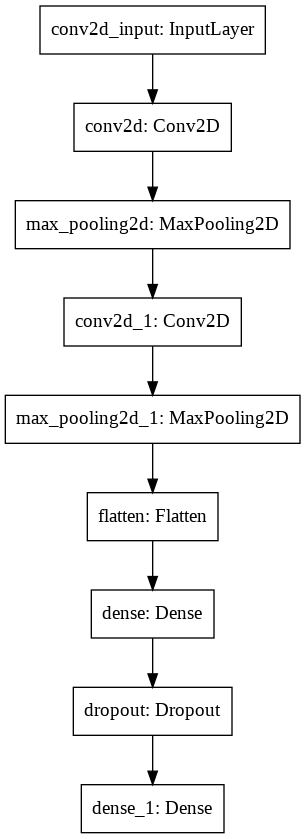

In [ ]:
keras.utils.plot_model(model)

위에서 출력한 plot_model을 보면 네모 상자 안의 내용 중 콜론 왼쪽에는 층의 이름이 쓰여있고, 오른쪽에는 클래스가 나타난다.

맨 처음에 나오는 InputLayer 클래스는 케라스가 자동으로 추가해 주는 것으로 입력층의 역할을 한다.

이 입력층은 첫번째 Conv2D 클래스에서 추가한 input_shape 매개변수를 사용한다.

plot_model()의 **show_shapes** 매개변수를 지정하면, 입,출력 크기를 표시해준다.

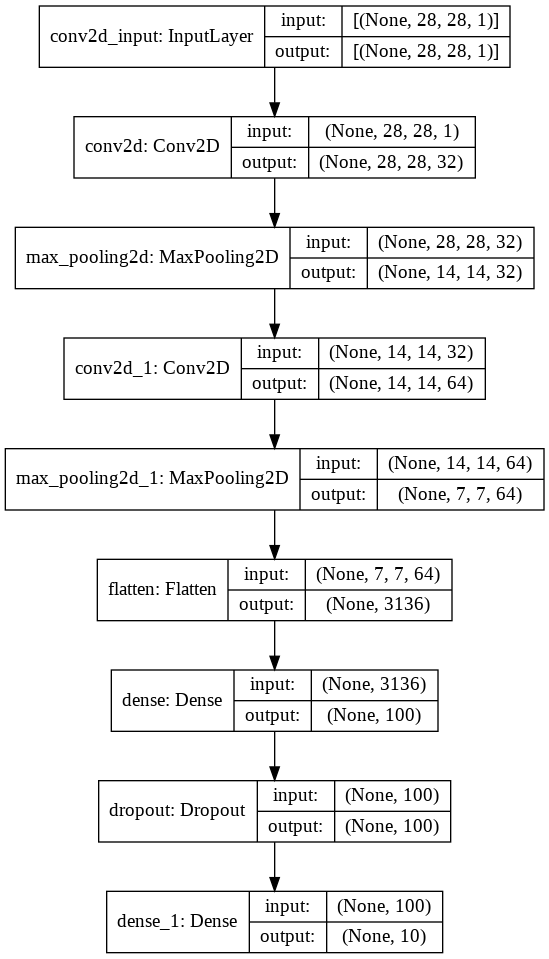

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

## 모델 컴파일과 훈련

케라스 API의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다.

Adam 옵티마이저를 사용하고, 콜백을 사용하여 조기 종료 기법을 구현하겠다.

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
history=model.fit(x_train,y_train,epochs=20,validation_data=(x_valid,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 11s 3ms/step - loss: 0.7048 - accuracy: 0.7464 - val_loss: 0.3258 - val_accuracy: 0.8788
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3545 - accuracy: 0.8720 - val_loss: 0.2766 - val_accuracy: 0.8956
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2958 - accuracy: 0.8940 - val_loss: 0.2738 - val_accuracy: 0.9013
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2578 - accuracy: 0.9067 - val_loss: 0.2372 - val_accuracy: 0.9099
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2397 - accuracy: 0.9124 - val_loss: 0.2285 - val_accuracy: 0.9139
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2141 - accuracy: 0.9223 - val_loss: 0.2266 - val_accuracy: 0.9156
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1983 - accuracy: 0.9257 - val_loss: 0.2212 - val_accuracy

Epoch가 11번째에서 끝났기 때문에 9번째 에포크에서 가장 검증 손실이 작을 것이다.

matplotlib를 사용하여 그래프를 손실 곡선을 그려보겠다.

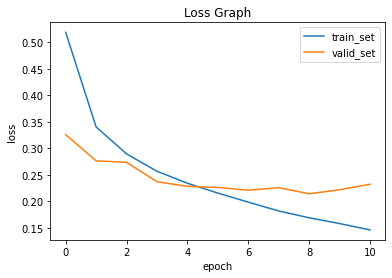

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Graph')
plt.legend(['train_set','valid_set'])
plt.show()

예상했던 대로, 위 그래프에선 인덱스가 0부터 시작하여 8번째에서 검증 손실이 작지만, 

즉 9번째 에포크에서 손실이 가장 작은 것을 알 수 있다.

EarlyStopping 클래스에서 restore_best_weights 매개변수를 지정했으므로, 현재 model 객체에는

최적의 모델 파라미터로 복원되어있다.(epoch=9일 때의 파라미터들)

model의 evaluate()를 사용하여 검증 데이터에 대한 성능 평가를 해보겠다.

In [ ]:
model.evaluate(x_valid,y_valid)

375/375 [==============================] - 1s 2ms/step - loss: 0.2145 - accuracy: 0.9237


[0.21454352140426636, 0.9236666560173035]

역시 모델의 fit() 과정에서와 마찬가지로 9번째 에포크일때와 같은 것을 볼 수 있다.

검증 데이터의 첫번째 원소를 확인해보고, model의 predict()를 활용하여 예측값을 확인한다.

이때 predict() 메소드에 데이터를 전달할 때 슬라이싱을 사용한다.

**keras의 fit(),predict(),evaluate() 메소드는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대하기 때문에, 한가지 샘플을 선택할 때, 슬라이싱을 사용하여 선택하여 전체 차원을 유지해준 채로 전달한다.**

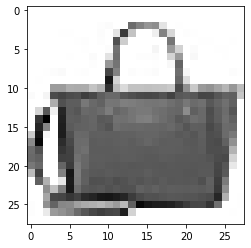

In [ ]:
plt.imshow(x_valid[0].reshape(28,28),cmap='gray_r')
plt.show()

In [ ]:
preds=model.predict(x_valid[0:1])
print(preds)

[[1.3004675e-19 1.9704648e-28 2.2547970e-24 2.2271621e-22 1.2487195e-22
  6.9793642e-17 1.9288172e-21 7.4852853e-23 1.0000000e+00 2.0030537e-20]]


위의 결과들을 막대그래프를 그려서 표현하면 더 명확하게 알 수 있다.

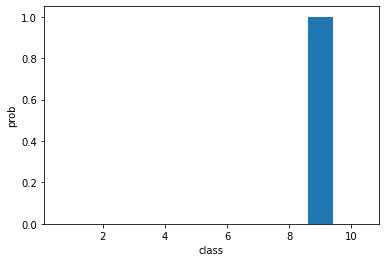

In [ ]:
plt.bar(range(1,11),preds[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

In [ ]:
classes=['티셔츠','바지','스웨터','드레스','코트','샌달','셔츠','스니커즈','가방','앵클부츠']

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [ ]:
x_test=x_test.reshape(-1,28,28,1)/255.0

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2426 - accuracy: 0.9178


[0.2425745576620102, 0.9178000092506409]

# 합성곱 신경망의 시각화

합성곱 층의 가중치와 특성 맵을 시각화하여 신경망이 이미지에서 어떤 것을 학습하지는 이해한다.

데이터는 패션MNIST dataset을 계속해서 이용하고, 모델은 합성곱 신경망 모델을 불러와서 사용한다.

## 가중치 시각화

keras.models의 load_model()을 사용하여 앞에서 했던 모델을 가져온다.

In [ ]:
model=keras.models.load_model('best-cnn-model.h5')

케라스 모델에 추가한 층은 **layers** 속성에 저장되어 있다.

이 속성은 파이썬 리스트이다.

In [ ]:
model.layers

층의 가중치와 절편은 층의 **weights** 속성에 저장되어 있다.

weights 또한 파이썬 리스트인데, weights의 첫 번째 원소는 가중치들이고, 

두 번째 원소는 절편을 저장하고있다.

In [ ]:
conv=model.layers[0]
print(conv.weights[0].shape,conv.weights[1].shape)

(3, 3, 1, 32) (32,)


weights 속성은 tensorflow의 다차원 배열인 Tensor 클래스 객체이다.

다루기 쉽도록 numpy 배열로 변환하고, 가중치 배열의 평균과 표준편차를 계산한다.

In [ ]:
conv_weights=conv.weights[0].numpy()
print(conv_weights.mean(),conv_weights.std())

-0.03167769 0.2782142


가중치의 평균은 0에 가깝고 분산은 0.28 정도 된다.

이 가중치들의 분포를 matplotlib의 히스토그램을 사용하여 나타낸다.

matplotlib의 히스토그램은 1차원 배열로 전달해야하기 떄문에, reshape()를 이용하여 바꿔준다.

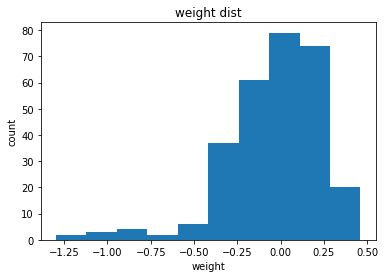

In [ ]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.title('weight dist')
plt.show()

이번에는 32개의 커널을 16개씩 2줄에 출력을 해본다.

imshow() 함수는 배열에 있는 최대값과 최소값을 사용해 픽셀의 강도를 표현한다.

따라서 두 배열을 비교하기가 쉽지 않다. 어떤 절댓값으로 기준을 정해서 픽셀의 강도를 나타내야 비교하기 좋을 것이다.

따라서 imshow()함수의 매개변수 **vmin**과 **vmax** 로 matplotlib의 컬러맵으로 표현할 범위를 지정한다.



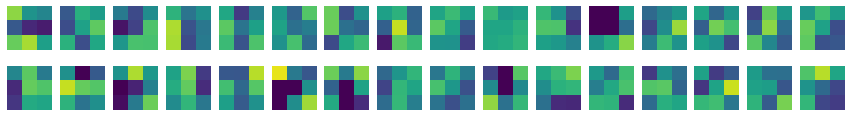

In [ ]:
fig, ax=plt.subplots(2,16,figsize=(15,2))
for i in range(2):
  for j in range(16):
    ax[i,j].imshow(conv_weights[:,:,0,16*i+j],vmin=-0.5,vmax=0.5)
    ax[i,j].axis('off')
plt.show()

결과 그래프를 보면 이 가중치 값이 무작위로 나열된 것이 아닌 어떤 패턴을 볼 수 있다.

첫 번째 가중치를 보면 맨 아래쪽 픽셀 값이 높아 아래쪽에 있는 직선을 만나면 크게 활성화될 것이다.

이번엔 합성곱 층의 가중치가 위에서 본 훈련된 가중치와 어떻게 다른지 알아본다.

In [ ]:
no_training_model=keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same',input_shape=(28,28,1)))

똑같이 keras의 Sequential() 클래스를 활용하여 모델을 만들고, 

layers 속성을 이용해 합성곱 층만 추출한다.

In [ ]:
no_training_conv=no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights=no_training_conv.weights[0].numpy()
print(no_training_weights.mean(),no_training_weights.std())

0.005316319 0.08301788


훈련된 가중치들과 비교하면 평균은 0으로 비슷하지만, 

훈련된 가중치들보다 훈련하지 않은 가중치들이 표준편차가 매우 작은 것을 알 수 있다.

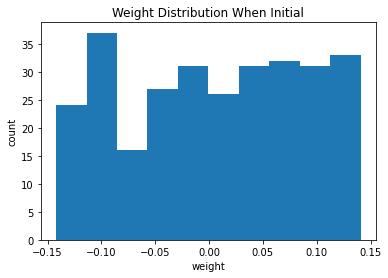

In [ ]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.title('Weight Distribution When Initial')
plt.show()

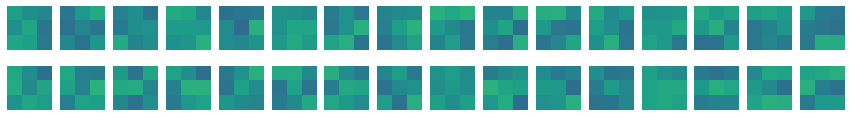

In [ ]:
fig, ax=plt.subplots(2,16,figsize=(15,2))
for i in range(2):
  for j in range(16):
    ax[i,j].imshow(no_training_weights[:,:,0,16*i+j],vmin=-0.5,vmax=0.5)
    ax[i,j].axis('off')
plt.show()

가중치들을 이용하여 어떤 방식으로 합성곱 층이 진행되는지 알 수 있었다.

이 외에도 합성곱 신경망의 학습을 시각화하는 방법으로 특성 맵을 그려보는 방법이 있다.

특성 맵을 그려보기에 앞서 필요한 함수형 API에대해 먼저 알아보겠다.

## 함수형 API

딥러닝에서는 좀 더 복작합 모델이 있을 수 있다.

입력이 2개일 수도 있고 출력이 2개 일 수도 있다.

이러한 모델들은 Sequential 클래스를 사용하기가 어려운데 이를 해결하기 위해 **함수형 API**를 사용한다. 

함수형 API는 케라스의 Model 클래스를 사용하여 모델을 만든다.

먼저 밀집층 2개를 만들고, InputLayer 층을 만든다.

Sequential()에서는 자동으로 만들어주지만, 함수형 API를 사용할 경우에는 직접 만들어야 한다.

keras는 InputLayer 클래스 객체를 쉽게 다룰 수 있도록 **Input()**를 제공한다.

입력의 크기를 지정하는 shape 매개변수를 함께 이 함수를 호출하면 InputLayer 클래스를 반환한다.



In [ ]:
dense1=keras.layers.Dense(100,activation='sigmoid')
dense2=keras.layers.Dense(10,activation='softmax')

In [ ]:
inputs=keras.Input(shape=(784,))

In [ ]:
hidden=dense1(inputs)

In [ ]:
outputs=dense2(hidden)

입력에서 출력까지 층을 호출한 결과를 계속 이어주고, Model 클래스에 입력과 최종 출력을 지정한다.

In [ ]:
model2=keras.Model(inputs,outputs)

model 객체의 predict() 메소드를 사용하면 입력부터 마지막 층까지 모든 계산을 수행한 후 

최종 출력을 반환한다. 하지만 우리가 필요한 것은 특성 맵이기때문에, 

합성곱 층까지의 결과를 반환하도록 해야한다.

첫 번째 층의 출력은 Conv2D 객체의 output 속성을 이용하여 얻을 수 있고,

model 객체의 입력은 keras 모델의 input 속성으로 입력을 참조할 수 있다.

In [ ]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [ ]:
conv_acti=keras.models.Model(model.input,model.layers[0].output)

## 특성맵 시각화

train_set에 있는 첫 번째 샘플을 그려보겠다.

(60000, 28, 28)


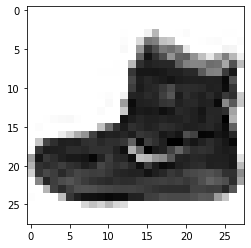

In [ ]:
(train_input,train_target),(test_input,test_input)=keras.datasets.fashion_mnist.load_data()
print(train_input.shape)
plt.imshow(train_input[0],cmap='gray_r')
plt.show()

부츠를 나타내고 있는데, 첫 번째 샘플을 이용하여 합성곱 층에서 만드는 특성 맵을 출력해보겠다.

이 때 하나의 층을 전달하더라도 꼭 첫 번째 차원을 유지해야 한다.

이를 위해 슬라이싱 연산자를 사용해 데이터를 추출하고, 표준화 시켜 신경망에 투입한다.

In [ ]:
inputs=train_input[:1].reshape(-1,28,28,1)/255.0
feature_maps=conv_acti.predict(inputs)

In [ ]:
print(feature_maps.shape)

(1, 28, 28, 32)


이 부츠를 사용한 특성 맵들을 imshow() 메소드를 이용하여 그려보겠다.

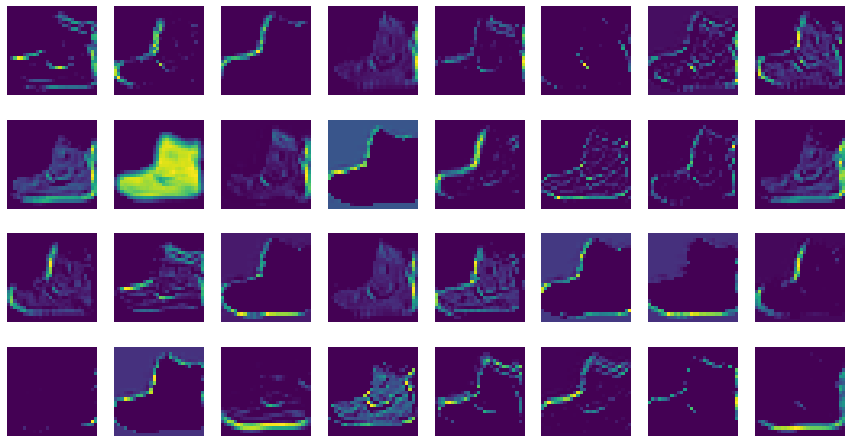

In [ ]:
fig, ax=plt.subplots(4,8,figsize=(15,8))
for i in range(4):
  for j in range(8):
    ax[i,j].imshow(feature_maps[0,:,:,8*i+j])
    ax[i,j].axis('off')
plt.show()

이 특성 맵은 32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분을 보여준다.

전에 가중치를 그려봤을 때 첫 번째를 기억해보면, 맨 아래에 있는 수평선을 감지한다. 따라서 첫 번째 특성 맵을 보면 수평선 특성이 잘 들어나는 것 같다.

두 번째 합성곱 층이 만든 특성 맵도 같은 방식으로 확인할 수 있다.

똑같이 함수형API 방식을 이용하여, Model 클래스에 입력과 출력을 정해준다.

In [ ]:
conv2_acti=keras.models.Model(model.input,model.layers[2].output)
feature_maps2=conv2_acti.predict(inputs)
print(feature_maps2.shape)

(1, 14, 14, 64)


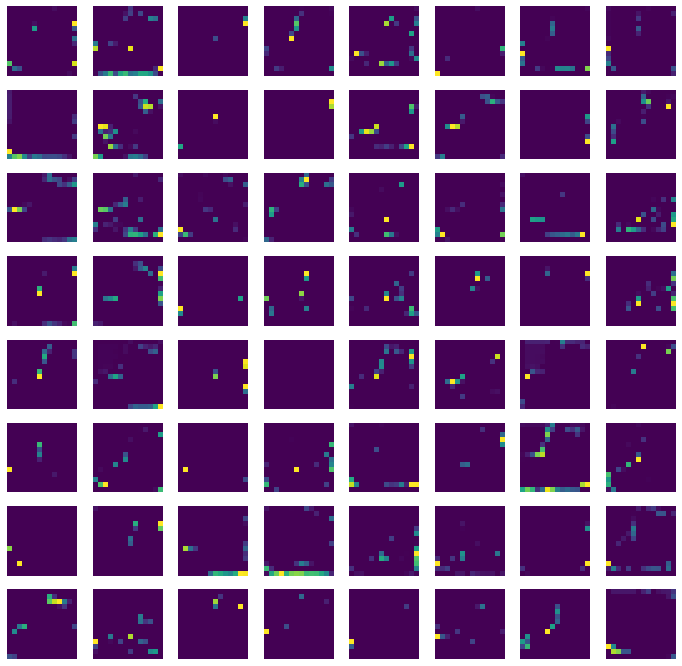

In [ ]:
fig, ax=plt.subplots(8,8,figsize=(12,12))
for i in range(8):
  for j in range(8):
    ax[i,j].imshow(feature_maps2[0,:,:,8*i+j])
    ax[i,j].axis('off')
plt.show()

두 번째 합성곱 층으로 나온 특성 맵들은 시각적으로 이해하기 어렵다.

두 번째 합성곱 층의 첫 번째 필터가 앞서 출력한 32개의 특성 맵과 곱해져 

두 번째 합성곱 층의 첫 번째 특성 맵이 된다.

따라서 위의 그림처럼 이렇게 계산된 출력은 (14,14,32) 특성 맵에서 어떤 부위를
 
감지하는지 직관적으로 이해하기가 힘들다.

이런 현상은 합성곱 층을 많이 쌓을수록 심해진다. 

즉 합성곱 신경망의 앞부분에 있는 합성곱 층은 이미지의 시각적인 정보를 감지하고, 

뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 

추상적인 정보를 학습한다고 볼 수 있다.